# SETUP

In [1]:
# !pip install dezero
# !pip install dezerogym

# dezero1.py

In [2]:
import numpy as np
from dezero import Variable
import dezero.functions as F

In [3]:
# Inner products
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
a, b = Variable(a), Variable(b)  # Optional
c = F.matmul(a, b)
print(c)

variable(32)


In [4]:
# Matrix product
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])
c = F.matmul(a, b)
print(c)

variable([[19 22]
          [43 50]])


# dezero2.py

In [5]:
import numpy as np
from dezero import Variable

In [6]:
def rosenbrock(x0, x1):
    y = 100 * (x1 - x0 ** 2) ** 2 + (x0 - 1) ** 2
    return y


In [7]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))

In [8]:
lr = 0.001
iters = 10000

In [9]:
for i in range(iters):
    y = rosenbrock(x0, x1)

    x0.cleargrad()
    x1.cleargrad()
    y.backward()

    x0.data -= lr * x0.grad.data
    x1.data -= lr * x1.grad.data

In [10]:
print(x0, x1)

variable(0.9944984367782456) variable(0.9890050527419593)


# dezero3.py

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from dezero import Variable
import dezero.functions as F

In [12]:
# toy data set
np.random.seed(0)
x = np.random.rand(100, 1)
y = 5 + 2 * x + np.random.rand(100, 1)
x, y = Variable(x), Variable(y) # 생략 가능

In [13]:
W = Variable(np.zeros((1, 1)))
b = Variable(np.zeros(1))

In [14]:
def predict(x):
    y = F.matmul(x, W) + b
    return y

In [15]:
def mean_squared_error(x0, x1):
    diff = x0 - x1
    return F.sum(diff ** 2) / len(diff)

In [16]:
lr = 0.1
iters = 100

In [17]:
for i in range(iters):
    y_pred = predict(x)
    loss = mean_squared_error(y, y_pred)

    W.cleargrad()
    b.cleargrad()
    loss.backward()

    W.data -= lr * W.grad.data
    b.data -= lr * b.grad.data

    if i % 10 == 0:
        print(loss.data)

42.296340129442335
0.24915731977561134
0.10078974954301652
0.09461859803040694
0.0902667138137311
0.08694585483964615
0.08441084206493275
0.08247571022229121
0.08099850454041051
0.07987086218625004


In [18]:
print('W =', W.data)
print('b =', b.data)

W = [[2.11807369]]
b = [5.46608905]


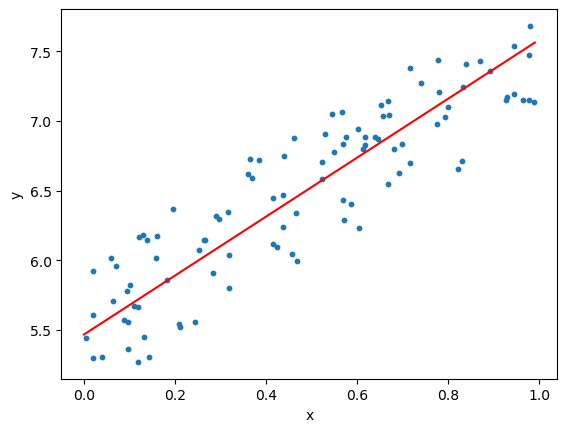

In [19]:
# Plot
plt.scatter(x.data, y.data, s=10)
plt.xlabel('x')
plt.ylabel('y')
t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = predict(t)
plt.plot(t, y_pred.data, color='r')
plt.show()

# dezero4.py

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from dezero import Model
from dezero import optimizers
import dezero.layers as L
import dezero.functions as F

In [21]:
# Dataset
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

In [22]:
lr = 0.2
iters = 10000

In [23]:
class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y

In [24]:
model = TwoLayerNet(10, 1)
optimizer = optimizers.SGD(lr)
optimizer.setup(model)

In [26]:
for i in range(iters):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward()

    optimizer.update()
    if i % 1000 == 0:
        print(loss.data)

0.8165178492839196
0.24990280802148895
0.24609876581126014
0.2372159081431807
0.20793216413350174
0.12311905720649356
0.0788816650635515
0.07655073683421637
0.07637803086238226
0.07618764131185567


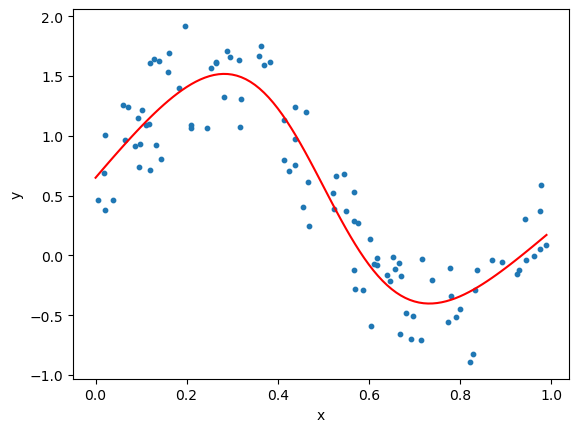

In [27]:
# Plot
plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')
t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = model(t)
plt.plot(t, y_pred.data, color='r')
plt.show()

# q_learning_nn.py

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L
from dezerogym.gridworld import GridWorld


In [29]:
def one_hot(state):
    HEIGHT, WIDTH = 3, 4
    vec = np.zeros(HEIGHT * WIDTH, dtype=np.float32)
    y, x = state
    idx = WIDTH * y + x
    vec[idx] = 1.0
    return vec[np.newaxis, :]

In [30]:
class QNet(Model):
    def __init__(self):
        super().__init__()
        self.l1 = L.Linear(100)  # hidden_size
        self.l2 = L.Linear(4)  # action_size

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [31]:
class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.lr = 0.01
        self.epsilon = 0.1
        self.action_size = 4

        self.qnet = QNet()
        self.optimizer = optimizers.SGD(self.lr)
        self.optimizer.setup(self.qnet)

    def get_action(self, state_vec):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            qs = self.qnet(state_vec)
            return qs.data.argmax()

    def update(self, state, action, reward, next_state, done):
        if done:
            next_q = np.zeros(1)  # [0.]
        else:
            next_qs = self.qnet(next_state)
            next_q = next_qs.max(axis=1)
            next_q.unchain()

        target = self.gamma * next_q + reward
        qs = self.qnet(state)
        q = qs[:, action]
        loss = F.mean_squared_error(target, q)

        self.qnet.cleargrads()
        loss.backward()
        self.optimizer.update()

        return loss.data

In [32]:
env = GridWorld()
agent = QLearningAgent()

In [33]:
episodes = 1000
loss_history = []

In [34]:
for episode in range(episodes):
    state = env.reset()
    state = one_hot(state)
    total_loss, cnt = 0, 0
    done = False

    while not done:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        next_state = one_hot(next_state)

        loss = agent.update(state, action, reward, next_state, done)
        total_loss += loss
        cnt += 1
        state = next_state

    average_loss = total_loss / cnt
    loss_history.append(average_loss)


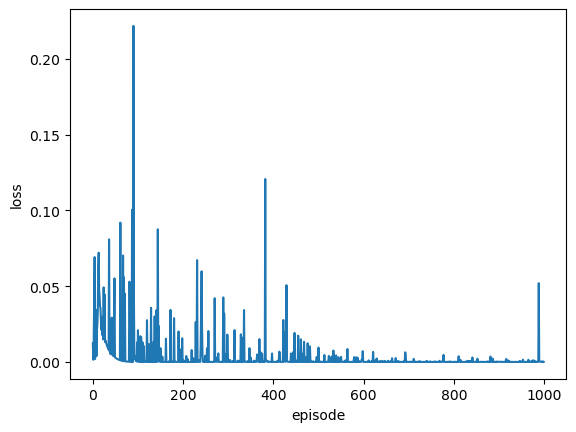

In [35]:
plt.xlabel('episode')
plt.ylabel('loss')
plt.plot(range(len(loss_history)), loss_history)
plt.show()

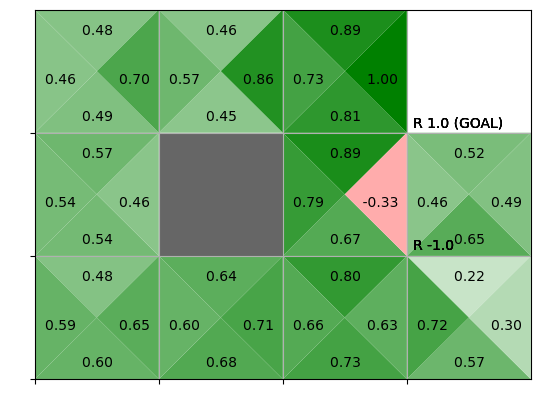

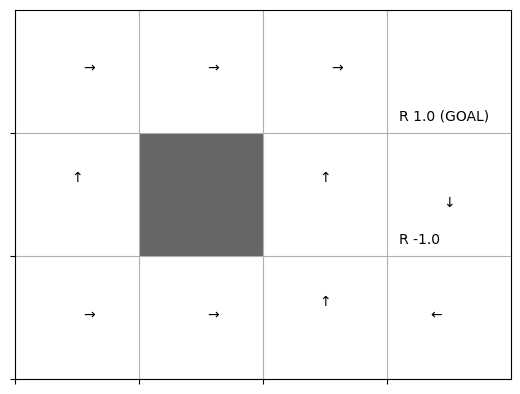

In [36]:
# visualize
Q = {}
for state in env.states():
    for action in env.action_space:
        q = agent.qnet(one_hot(state))[:, action]
        Q[state, action] = float(q.data)
env.render_q(Q)